In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import gaussian_kde, norm, median_abs_deviation

In [176]:
class Ruppert_Chapter4_Exercises_Solutions:
    def __init__(self, filepath, column_name='FORD', company='Ford'):
        self.df = pd.read_csv(filepath)
        self.returns = self.df[column_name].dropna()
        self.n = len(self.returns)
        self.median = np.median(self.returns)
        self.company = company

    def compute_standard_errors(self, returns):
        kde = gaussian_kde(returns)
        f_median = kde.evaluate(np.median(returns))[0]
        se_median = 1 / (2 * f_median * np.sqrt(len(returns)))
        se_mean = returns.std() / np.sqrt(len(returns))
        return se_mean, se_median

    def plot_qq_plots(self, returns, df_list, title_prefix=""):
        for df_val in df_list:
            stats.probplot(returns, dist="t", sparams=(df_val,), plot=plt)
            plt.title(f"{title_prefix} t Q-Q Plot (df={df_val})")
            plt.show()

    def perform_shapiro_wilk_test(self, returns, alpha=0.01):
        stat, pvalue = stats.shapiro(returns)
        reject = pvalue < alpha
        return stat, pvalue, reject

    def solve_question1(self):
        print(f"\nQuestion 1: Analysis of {self.company} Returns ---")

        # (a) compute mean, median, and std
        mean = self.returns.mean()
        std = self.returns.std()
        print(f"(a) Sample mean: {mean:.6f}")
        print(f"    Sample median: {self.median:.6f}")
        print(f"    Sample standard deviation: {std:.6f}")

        # (b) Q-Q plot normal or not
        print("\n(b) Q-Q Plot against Normal Distribution:")
        stats.probplot(self.returns, dist="norm", plot=plt)
        plt.title(f"Normal Q-Q Plot of {self.company} Returns")
        plt.show()
        print("Observation: The points deviate from the line in the tails, indicating heavy tails (not normally distributed).")

        # (c) Shapiro-Wilk test
        stat, pvalue, reject = self.perform_shapiro_wilk_test(self.returns)
        print(f"\n(c) Shapiro-Wilk Test:")
        print(f"Test statistic: {stat:.4f}")
        print(f"p-value: {pvalue:.6f}")
        print(f"Reject normality at 0.01 level? {'Yes' if reject else 'No'}")

        # (d) t-distribution Q-Q plots
        print("\n(d) t-distribution Q-Q Plots (with various degrees of freedom):")
        df_list = [1, 2, 5, 10, 20, 30]
        self.plot_qq_plots(self.returns, df_list, title_prefix="")

        trimmed = self.returns[self.returns > self.returns.quantile(0.001)]
        self.plot_qq_plots(trimmed, df_list, title_prefix="Excluding Outlier")

        print("\nIn the case of Ford stock returns, the extreme negative return from Black Monday creates a disproportionately long left tail in the Q-Q plot, causing a sharp deviation from the reference line. This single outlier exaggerates the tail behavior and distorts the visual assessment of the overall distribution. By removing it, the left tail becomes less extreme, and the Q-Q plot aligns more linearly with the theoretical quantiles of a t-distribution, offering a clearer picture of how well the bulk of the data fits the model with a very few outliers.")

        # (e) Standard error of sample median and mean
        se_mean, se_median = self.compute_standard_errors(self.returns)
        print(f"\n(e) Standard Error of Median: {se_median:.6f}")
        print(f"Standard Error of Mean:   {se_mean:.6f}")
        print(f"Observation: SE of median is {'larger' if se_median > se_mean else 'smaller'} than SE of mean.")

    def solve_question2(self):
        df_recent = pd.read_csv(r"C:\Users\ershf\Documents\Ruppert_Solutions\Statistics_and_data_analysis_for_financial_engineering\datasets\RecentFord.csv")
        
        # to make sure the dataset has at least 7 columns for adjusted close prices
        if df_recent.shape[1] < 7:
            raise ValueError("CSV must contain at least 7 columns for RecentFord.csv")

        df_recent['AdjClose'] = df_recent.iloc[:, 6]
        df_recent['Return'] = df_recent['AdjClose'].pct_change()
        returns = df_recent['Return'].dropna()
        median = np.median(returns)

        print("Recent Returns Statistics:")
        print(returns.describe())

        # extreme date with return approximately -0.175 by rounding to 3 decimal places
        match = df_recent[np.round(df_recent['Return'], 3) == -0.175]
        if not match.empty:
            extreme_date = match.iloc[0, 0]  # assuming the first column is the date
            extreme_return = match['Return'].values[0]
            print(f"Extreme return of {extreme_return:.4f} occurred on: {extreme_date}")
        
            # Explanation of Ford’s stock drop on May 12, 2009
            print("\nExplanation:")
            print("On May 12, 2009, Ford's stock dropped sharply by approximately 17.5%.")
            print("This drop came after a massive 22% rally the day before, driven by a strategic debt restructuring plan.")
            print("The pullback was likely due to profit-taking, as investors who benefitted from the sudden surge began selling their shares.")
            print("Additionally, the broader market saw mixed signals on that day, contributing to volatility.")
            print("Sources:")
            print(" - Reuters, May 12, 2009: https://www.reuters.com/article/us-markets-stocks-idUSTRE54B6K920090512")
            print(" - CNN Money: 'Ford shares fall after big run-up', archived article from May 2009")
        else:
            print("No return approximately equal to -0.175 was found.")

        # Q-Q Plot against normal distribution
        stats.probplot(returns, dist="norm", plot=plt)
        plt.title("Normal Q-Q Plot of Recent Ford Returns")
        plt.show()

        # Shapiro-Wilk normality test
        stat, pvalue, _ = self.perform_shapiro_wilk_test(returns)
        print(f"Shapiro-Wilk Test: statistic = {stat:.4f}, p-value = {pvalue:.4f}")

        # Q-Q plots against t-distributions
        df_list = [1, 2, 5, 10, 20, 30]
        self.plot_qq_plots(returns, df_list)

        # excluding the extreme return for better tail-fit and plot again
        returns_wo_outlier = returns[np.round(returns, 3) != -0.175]
        self.plot_qq_plots(returns_wo_outlier, df_list, title_prefix="Excluding ~-0.175 Return")

        print("For recent Ford stock returns, the extreme negative return observed on 5/12/2009 (approximately -0.175) introduces ")
        print("noticeable left-tail curvature in the Q-Q plot relative to a t-distribution. Although the tail is not particularly long, ")
        print("the pronounced concave deviation from the reference line indicates localized heavy-tailed behavior. Excluding this outlier ")
        print("mitigates the curvature, resulting in a Q-Q plot that more closely approximates linearity and better represents the fit of ")
        print("the central distributional mass to the assumed model.")
        # standard errors
        se_mean, se_median = self.compute_standard_errors(returns)
        print(f"SE of Mean: {se_mean:.6f}, SE of Median: {se_median:.6f}")

    def solve_question3(self):
        print("\nQuestion 3: Analysis of U.S. Dollar / Japanese Yen Exchange Rate (dy)")
        df_garch = pd.read_csv(r"C:\Users\ershf\Documents\Ruppert_Solutions\Chapter_3_solutions\bond_analytics\data\datasets\Garch.csv")
        
        dy = df_garch['dy'].dropna()
        d_dy = np.diff(dy)

        # Part (a): KDE with sample mean and std
        mean_dy = np.mean(d_dy)
        std_dy = np.std(d_dy)
        x_vals = np.linspace(min(d_dy), max(d_dy), 1000)

        kde = gaussian_kde(d_dy)
        kde_vals = kde.evaluate(x_vals)
        norm_vals = norm.pdf(x_vals, loc=mean_dy, scale=std_dy)

        plt.figure(figsize=(10, 6))
        plt.plot(x_vals, kde_vals, label="Kernel Density Estimate", color='blue')
        plt.plot(x_vals, norm_vals, linestyle='--', label="Normal Density (mean & std)", color='red')
        plt.title("Part (a): KDE vs Normal (mean & std)")
        plt.xlabel("First Differences of dy")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"(a) Sample mean: {mean_dy:.6f}, Sample std dev: {std_dy:.6f}")
        print("The figure compares the kernel density estimate (KDE) of the first differences of the variable dy to a normal distribution ")
        print("with the same mean and standard deviation. The KDE, shown as a solid blue line, provides a non-parametric estimate of the ")
        print("data's underlying probability distribution. The red dashed line represents a standard normal distribution centered at the ")
        print("empirical mean and scaled to the empirical standard deviation of the data. Visually, the KDE appears more sharply peaked in ")
        print("the center and exhibits heavier tails compared to the red dashed normal curve. This suggests that the actual distribution of ")
        print("the data is more leptokurtic—meaning it has more frequent extreme values—than what is predicted by a Gaussian distribution ")
        print("with matching first and second moments.")

        # Part (b): KDE with median and MAD
        median_dy = np.median(d_dy)
        mad_dy = median_abs_deviation(d_dy, scale='normal')  # scales to std for normal consistency

        norm_vals_median = norm.pdf(x_vals, loc=median_dy, scale=mad_dy)

        plt.figure(figsize=(10, 6))
        plt.plot(x_vals, kde_vals, label="Kernel Density Estimate", color='blue')
        plt.plot(x_vals, norm_vals_median, linestyle='--', label="Normal Density (median & MAD)", color='green')
        plt.title("Part (b): KDE vs Normal (median & MAD)")
        plt.xlabel("First Differences of dy")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"(b) Median: {median_dy:.6f}, MAD (scaled): {mad_dy:.6f}")
        print("This figure compares the same KDE of the first differences of dy to a normal distribution centered at the sample ")
        print("median and scaled using the median absolute deviation (MAD). The green dashed line in this plot represents a robustly ")
        print("parameterized normal distribution that is less sensitive to outliers than the one in Figure (a). By using the median and MAD, ")
        print("this distribution attempts to capture the central tendency and spread of the data in a way that is not overly influenced by ")
        print("extreme values. While the fit appears somewhat closer to the KDE at the center, it still fails to capture the fat tails seen in ")
        print("the empirical density. This reinforces the evidence that the data deviates from normality, exhibiting both peakedness and heavier ")
        print("tails, even under robust assumptions.")


Question 1: Analysis of Ford Returns ---
(a) Sample mean: 0.000760
    Sample median: 0.000000
    Sample standard deviation: 0.018316

(b) Q-Q Plot against Normal Distribution:


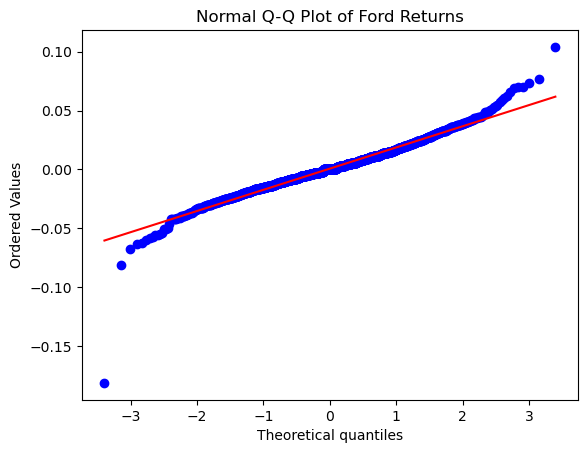

Observation: The points deviate from the line in the tails, indicating heavy tails (not normally distributed).

(c) Shapiro-Wilk Test:
Test statistic: 0.9639
p-value: 0.000000
Reject normality at 0.01 level? Yes

(d) t-distribution Q-Q Plots (with various degrees of freedom):


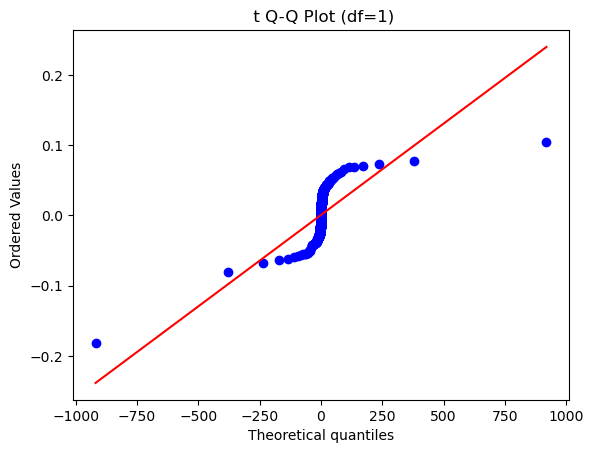

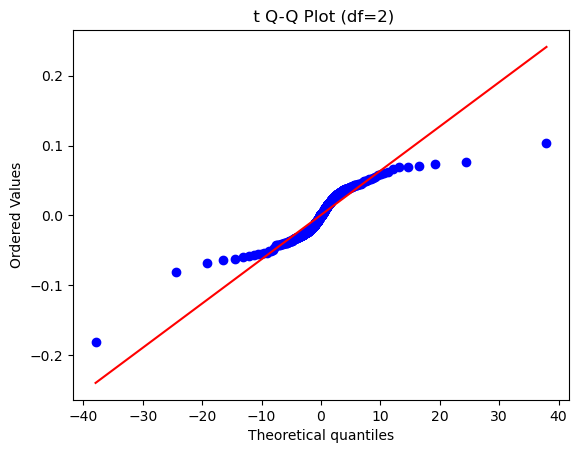

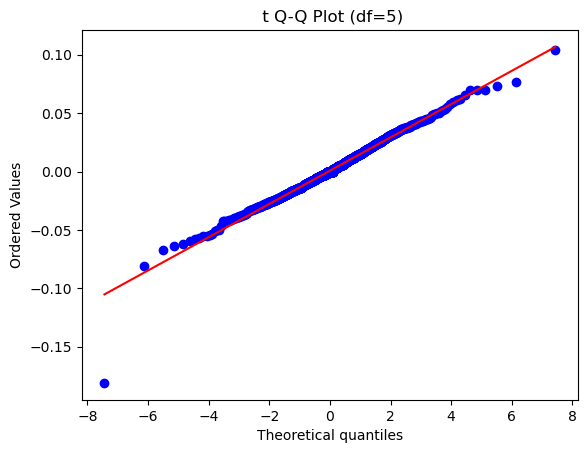

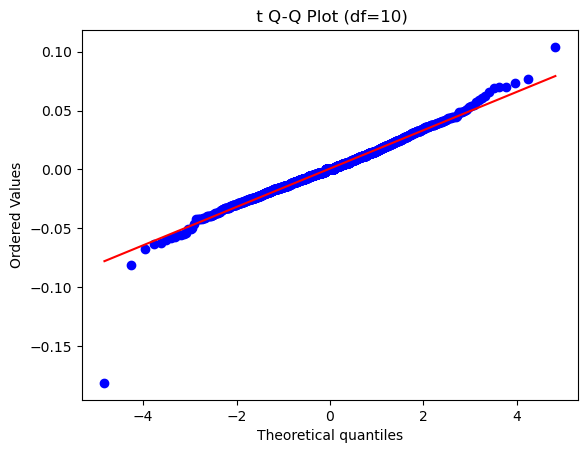

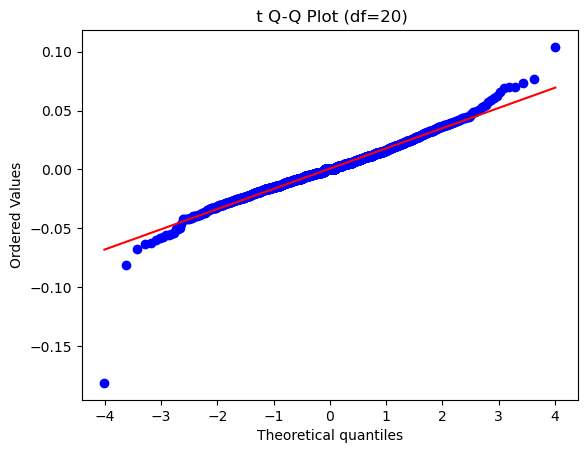

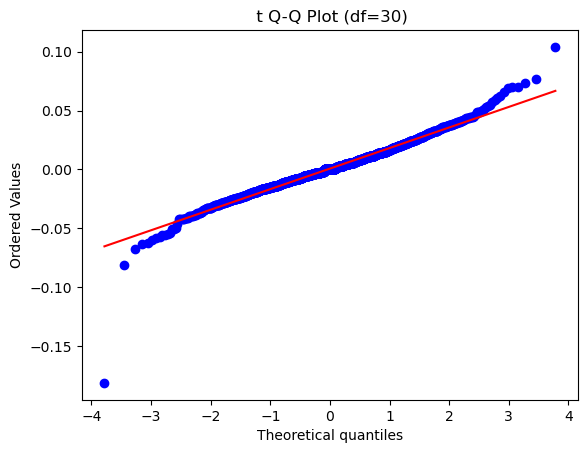

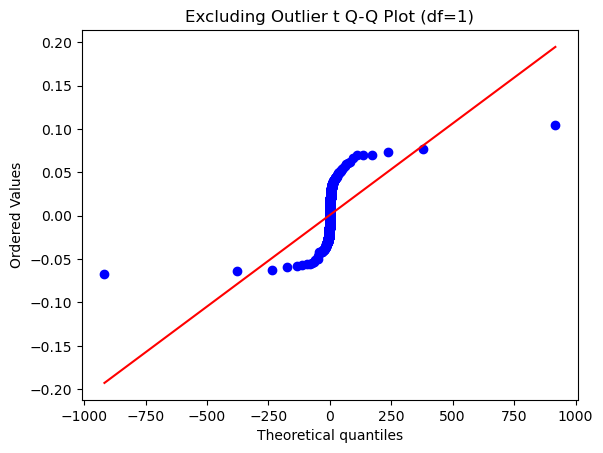

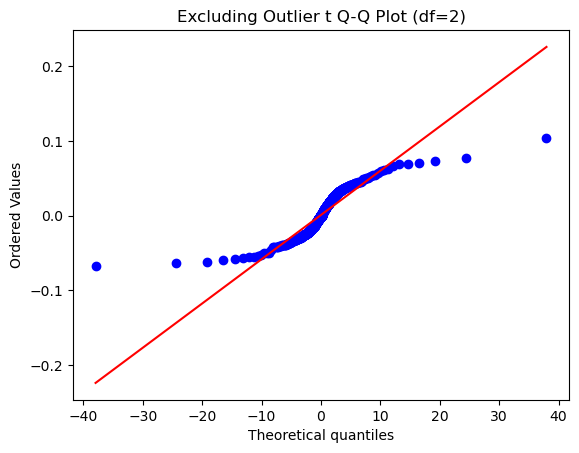

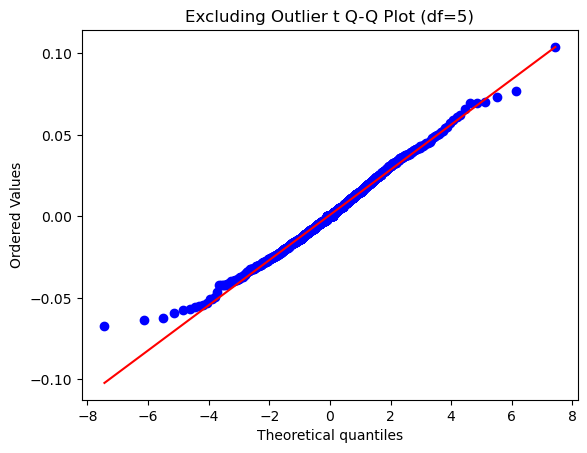

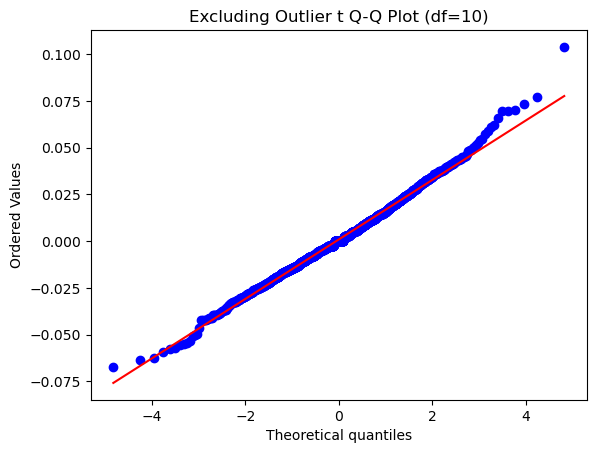

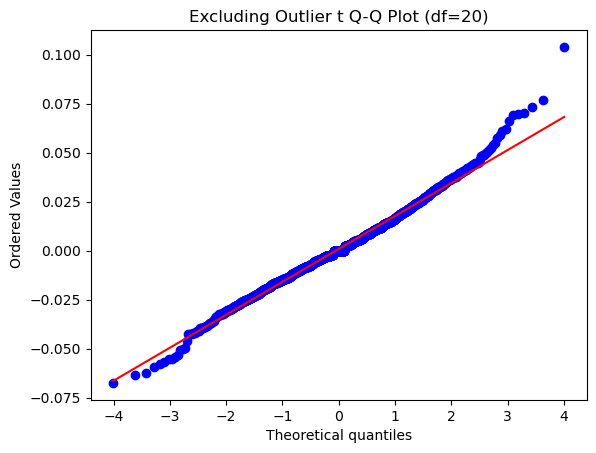

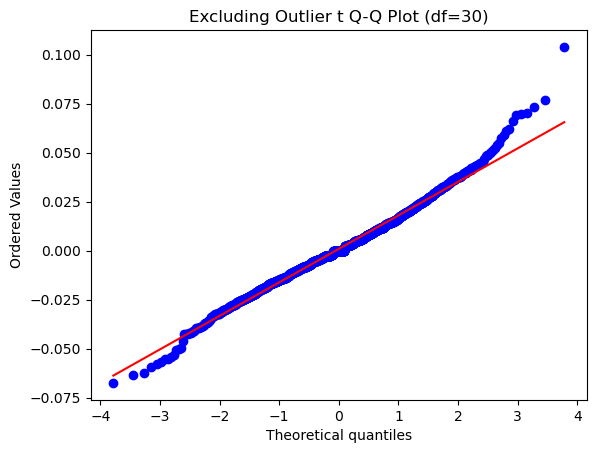


In the case of Ford stock returns, the extreme negative return from Black Monday creates a disproportionately long left tail in the Q-Q plot, causing a sharp deviation from the reference line. This single outlier exaggerates the tail behavior and distorts the visual assessment of the overall distribution. By removing it, the left tail becomes less extreme, and the Q-Q plot aligns more linearly with the theoretical quantiles of a t-distribution, offering a clearer picture of how well the bulk of the data fits the model with a very few outliers.

(e) Standard Error of Median: 0.000438
Standard Error of Mean:   0.000410
Observation: SE of median is larger than SE of mean.


In [178]:
solver = Ruppert_Chapter4_Exercises_Solutions(r"C:\Users\ershf\Documents\Ruppert_Solutions\Statistics_and_data_analysis_for_financial_engineering\book_code\fEcofin\ford.csv")
solver.solve_question1()

Recent Returns Statistics:
count    1257.000000
mean        0.001842
std         0.026417
min        -0.174825
25%        -0.011542
50%         0.000815
75%         0.014167
max         0.160131
Name: Return, dtype: float64
Extreme return of -0.1748 occurred on: 5/12/2009

Explanation:
On May 12, 2009, Ford's stock dropped sharply by approximately 17.5%.
This drop came after a massive 22% rally the day before, driven by a strategic debt restructuring plan.
The pullback was likely due to profit-taking, as investors who benefitted from the sudden surge began selling their shares.
Additionally, the broader market saw mixed signals on that day, contributing to volatility.
Sources:
 - Reuters, May 12, 2009: https://www.reuters.com/article/us-markets-stocks-idUSTRE54B6K920090512
 - CNN Money: 'Ford shares fall after big run-up', archived article from May 2009


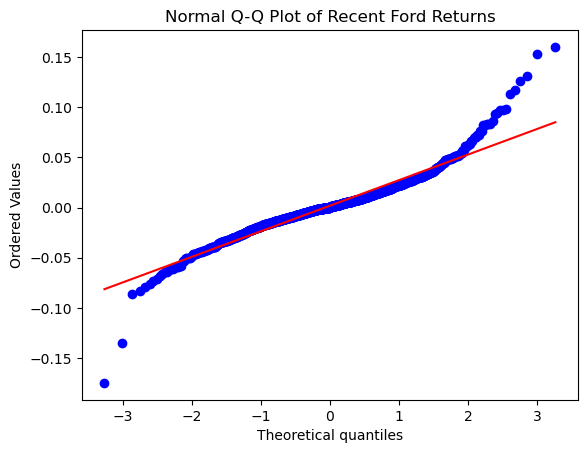

Shapiro-Wilk Test: statistic = 0.9315, p-value = 0.0000


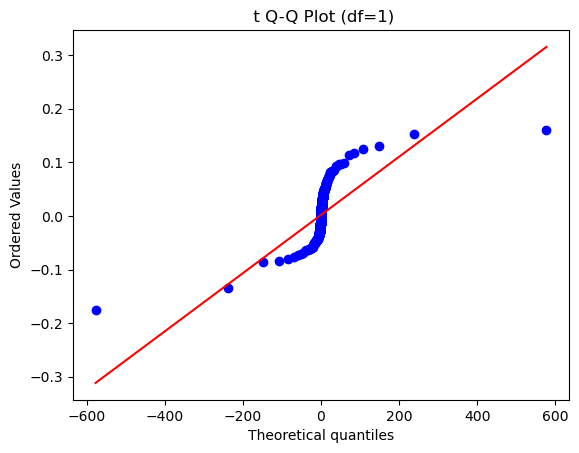

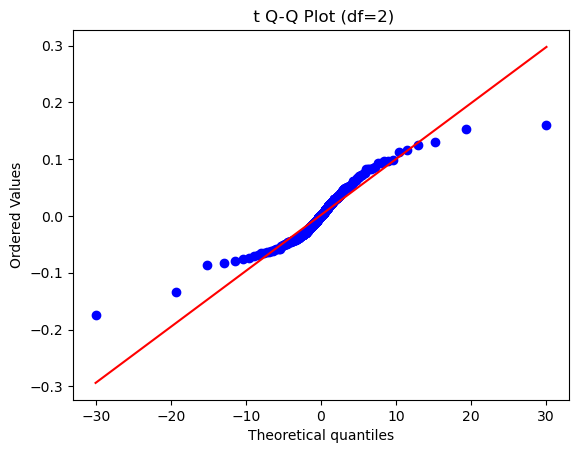

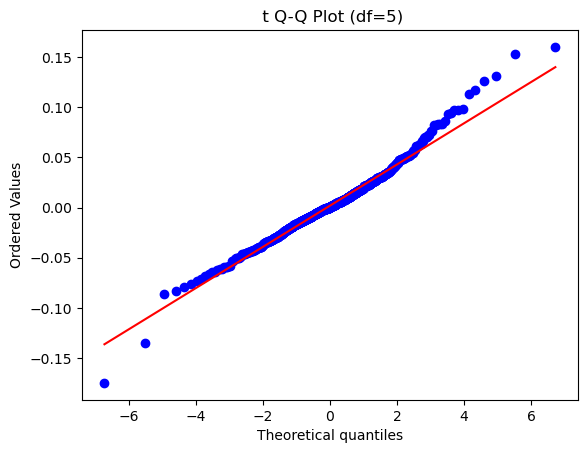

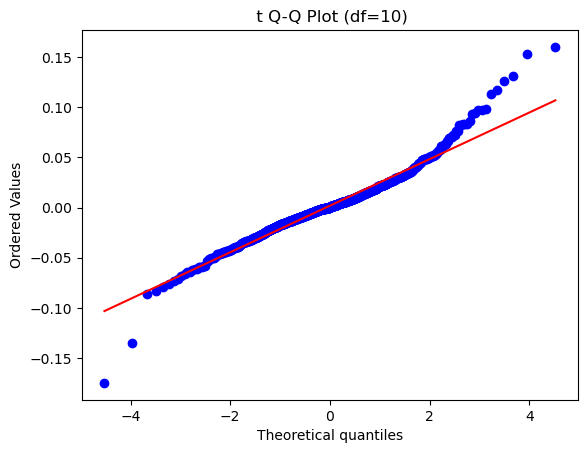

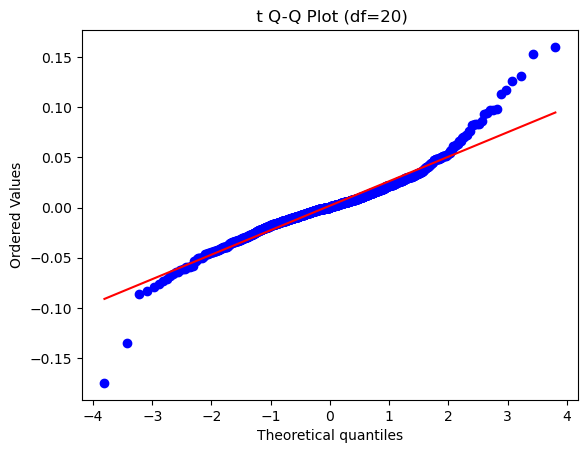

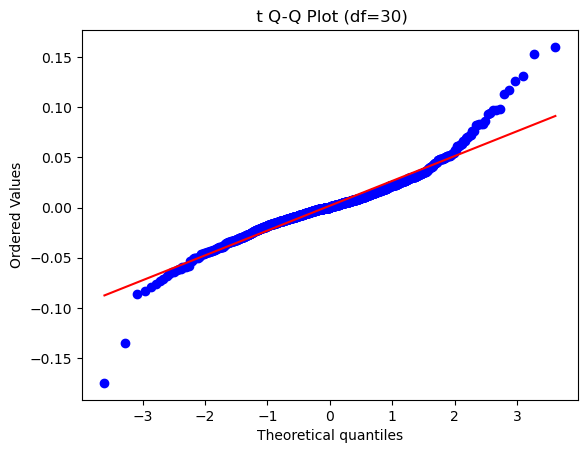

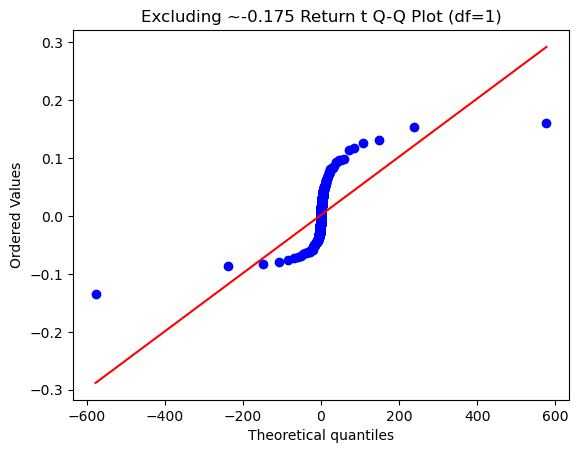

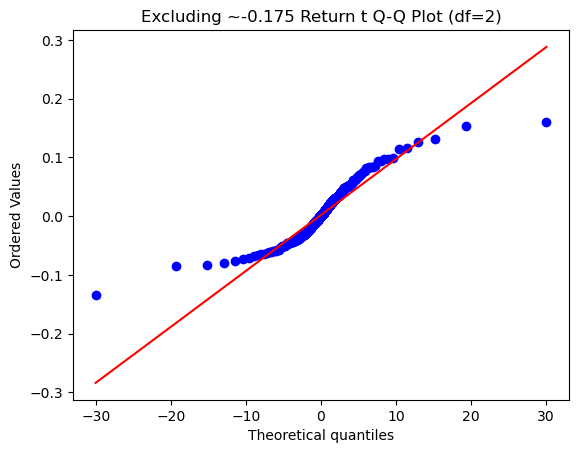

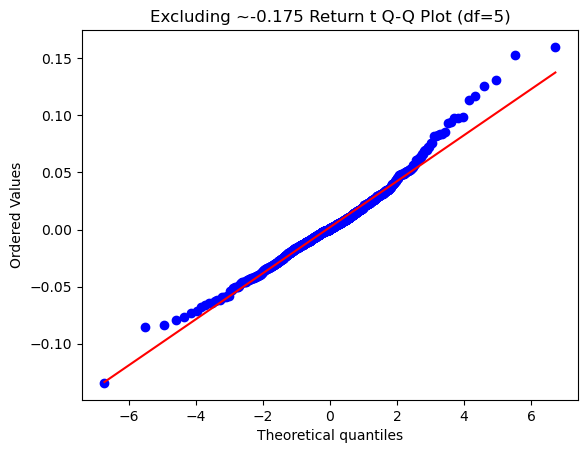

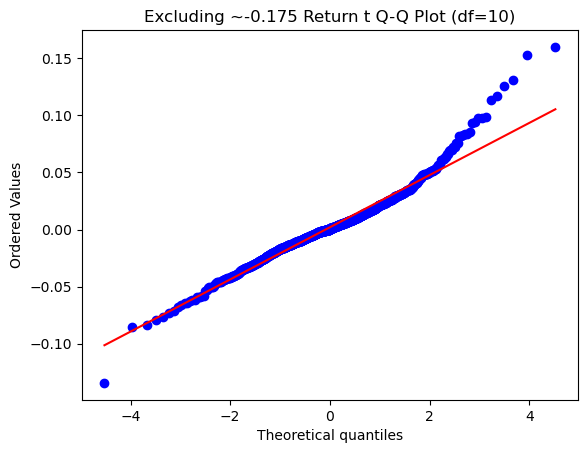

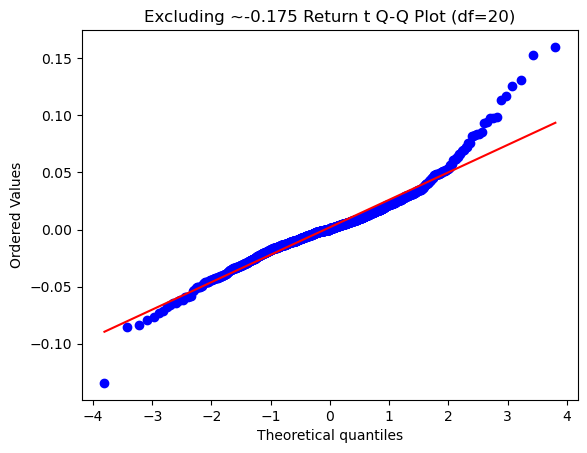

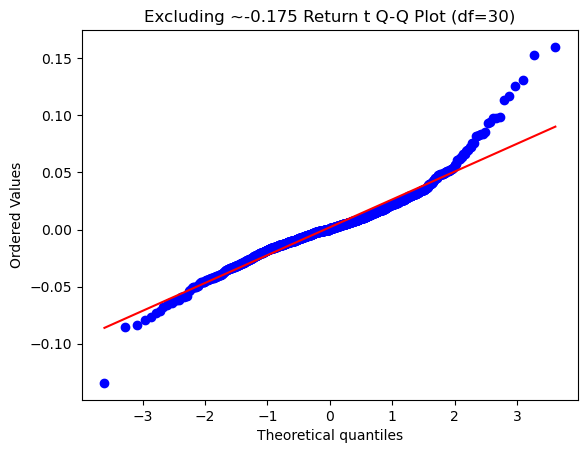

For recent Ford stock returns, the extreme negative return observed on 5/12/2009 (approximately -0.175) introduces 
noticeable left-tail curvature in the Q-Q plot relative to a t-distribution. Although the tail is not particularly long, 
the pronounced concave deviation from the reference line indicates localized heavy-tailed behavior. Excluding this outlier 
mitigates the curvature, resulting in a Q-Q plot that more closely approximates linearity and better represents the fit of 
the central distributional mass to the assumed model.
SE of Mean: 0.000745, SE of Median: 0.000676


In [154]:
solver.solve_question2()


Question 3: Analysis of U.S. Dollar / Japanese Yen Exchange Rate (dy)


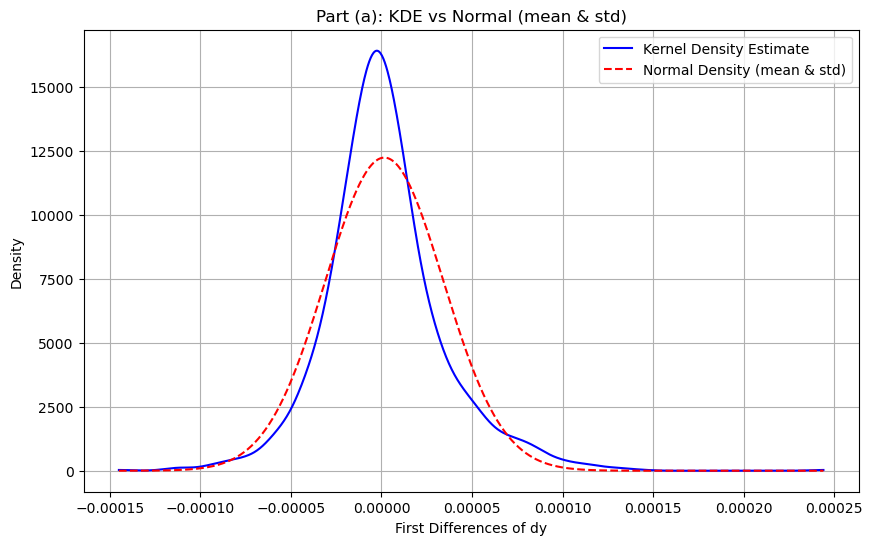

(a) Sample mean: 0.000002, Sample std dev: 0.000033
The figure compares the kernel density estimate (KDE) of the first differences of the variable dy to a normal distribution 
with the same mean and standard deviation. The KDE, shown as a solid blue line, provides a non-parametric estimate of the 
data's underlying probability distribution. The red dashed line represents a standard normal distribution centered at the 
empirical mean and scaled to the empirical standard deviation of the data. Visually, the KDE appears more sharply peaked in 
the center and exhibits heavier tails compared to the red dashed normal curve. This suggests that the actual distribution of 
the data is more leptokurtic—meaning it has more frequent extreme values—than what is predicted by a Gaussian distribution 
with matching first and second moments.


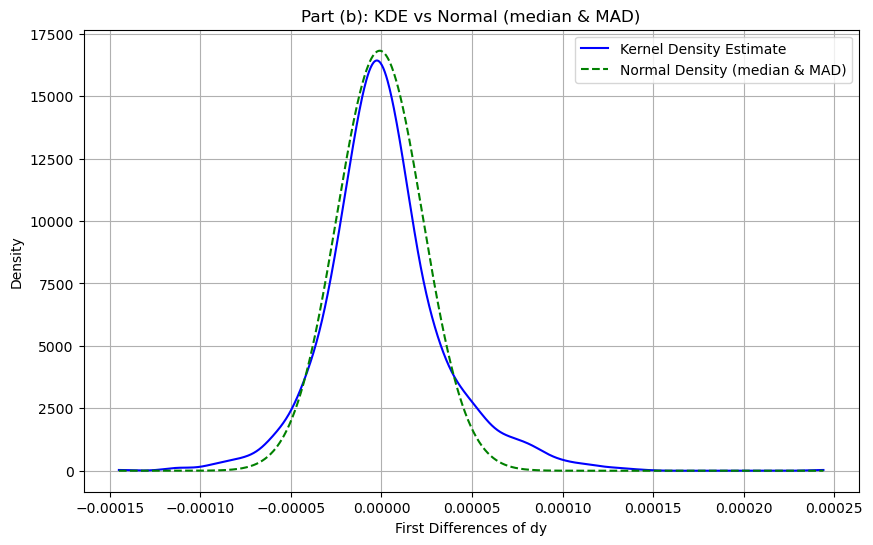

(b) Median: -0.000001, MAD (scaled): 0.000024
This figure compares the same KDE of the first differences of dy to a normal distribution centered at the sample 
median and scaled using the median absolute deviation (MAD). The green dashed line in this plot represents a robustly 
parameterized normal distribution that is less sensitive to outliers than the one in Figure (a). By using the median and MAD, 
this distribution attempts to capture the central tendency and spread of the data in a way that is not overly influenced by 
extreme values. While the fit appears somewhat closer to the KDE at the center, it still fails to capture the fat tails seen in 
the empirical density. This reinforces the evidence that the data deviates from normality, exhibiting both peakedness and heavier 
tails, even under robust assumptions.


In [180]:
solver.solve_question3()